In [1]:
import torch
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import torch.nn.functional as F
from collections import defaultdict
import copy
import sys
from scipy import ndimage
cmap=plt.cm.Spectral_r
from mpl_toolkits import mplot3d
from pathlib import Path
import string

sys.path.append('.')
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    #"text.usetex": True,
    "font.family": "serif",
    'font.size':16,
    "lines.linewidth":3.0,
    "savefig.dpi":500
})
cmap = plt.get_cmap('viridis')

savedir= './figs/'
if not os.path.exists(savedir):
    os.mkdir(savedir)

In [2]:
def find(array, value):
    idx= np.argwhere(np.array(array)==value)[0,0]
    return idx

def h2p(width, input_size, depth):
    return input_size*width + (depth-1) * width**2 + width
h2p = np.vectorize(h2p)

def select_runs(runs, params, constraints):
    selected_runs = []
    for irun, run in enumerate(runs):
        keep = True
        for k,v in constraints.items():
            if getattr(run['args'],k) != v:
                keep = False
                break
        if keep:
            selected_runs.append(run)
    selected_params = copy.deepcopy(params)
    for con in constraints:
        selected_params[con]=[constraints[con]]
    return selected_runs, selected_params

def group_runs(runs, finished_only=True):
    runs_grouped = defaultdict(list)
    for run in runs:
        seedless_args = copy.deepcopy(run['args'])
        del(seedless_args.seed)
        del(seedless_args.name)
        if str(seedless_args) not in runs_grouped.keys(): 
            runs_grouped[str(seedless_args)].append(run) # need at least one run
        else:
            if run['finished'] or not finished_only:
                runs_grouped[str(seedless_args)].append(run)
    runs_grouped = list(runs_grouped.values())
    return runs_grouped


In [3]:
# 1610892401 varying number of local layers
# 1610894815 subsampling 
# 1610922944 class token

runs = []
logs = []
indices = [-1]

for ind in indices:

    base = '/checkpoint/leventsagun/deit/'
    paths = sorted(glob.glob(base+'*'), key=os.path.getmtime)
    paths=[p for p in paths if not p.endswith('pyT')]
    print(paths)
    last = paths[ind]
    path = last
    #path = base+'r.1604516551'
    path += '/'
    print(path)

    dirnames = glob.glob(path+'*')
    dirnames = list(filter(lambda x : not x.endswith('init'), dirnames))
    print('{} runs found'.format(len(dirnames)))
    fails = 0
    for dirname in dirnames:
        try : 
            run = {}
            args = torch.load(dirname+'/args.pyT', map_location=torch.device('cpu'))
            run['args'] = args
            f = open(dirname+'/log.txt', "r")
            log = [eval(line) for line in f.readlines()]
            run['logs']=log
            runs.append(run)
        except: 
            print('failed {}'.format(dirname))
            fails += 1
    print('{} fails'.format(fails))
    
latest = min([len(run['logs']) for run in runs])-1
params = defaultdict(list)
for run in runs:
    for k,v in vars(run['args']).items():
        params[k].append(v)
for k in params:
    params[k] = sorted(list(set(params[k])))

['/checkpoint/leventsagun/deit/1610982363']
/checkpoint/leventsagun/deit/1610982363/
6 runs found
0 fails


# Varying number of local layers

In [401]:
runs[1]['logs'][0].keys()

dict_keys(['train_lr', 'train_loss', 'test_loss', 'test_acc1', 'test_acc5', 'attn_dist_0', 'attn_dist_1', 'epoch', 'n_parameters'])

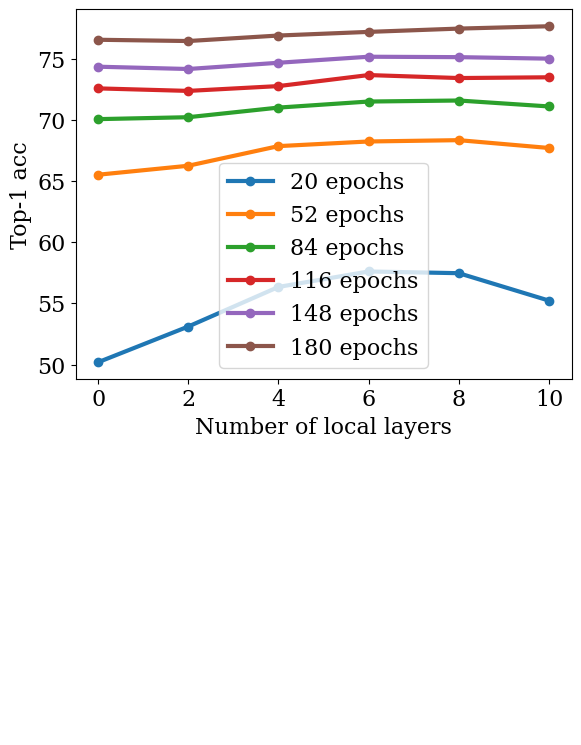

In [73]:
topk=1
times = range(20,latest-1,(latest-20)//5-1)
x, y = [], defaultdict(list)
for run in runs:
    x.append(run['args'].local_up_to_layer)
    for t in times:
        y[t].append(run['logs'][t]['test_acc{}'.format(topk)])
plt.annotate('Baseline',(min(x)+.1,min(y)+.1), color='red')
    
for t in times:
    plt.plot(x,y[t], marker='o', label='{} epochs'.format(t))
plt.legend()
plt.xlabel('Number of local layers')
plt.ylabel('Top-{} acc'.format(topk,latest))
plt.show()

186


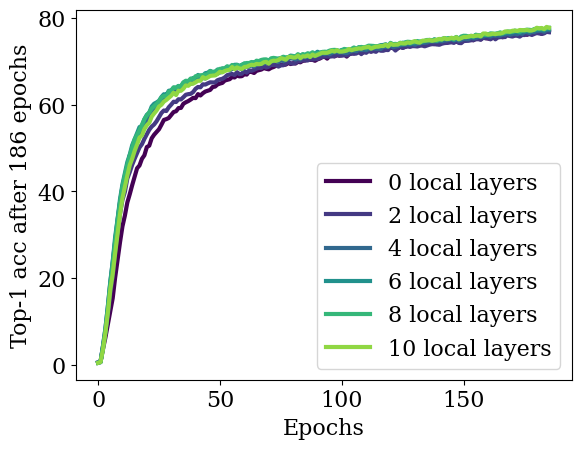

In [74]:
latest = min([len(run['logs']) for run in runs])-1
print(latest)
topk=1

plt.figure()

for run in runs:
    n_local = run['args'].local_up_to_layer
    plt.plot(range(latest), [run['logs'][k]['test_acc%d'%topk] for k in range(latest)], color=cmap(n_local/12), label='{} local layers'.format(n_local))
    #plt.plot(range(latest), [run['test'][k]['loss'] for k in range(latest)], color=cmap(n_local/12), label='{} local layers'.format(n_local))
    #plt.plot(range(latest), [run['train'][k]['loss'] for k in range(latest)], ls='--', color=cmap(n_local/12))
    
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Top-{} acc after {} epochs'.format(topk,latest))
plt.show()

# Varying sampling ratio

[300, 300]
0.01 300
[300, 300]
0.05 300
[300, 300]
0.1 300
[88, 212]
0.5 88
[128, 122]
1.0 122


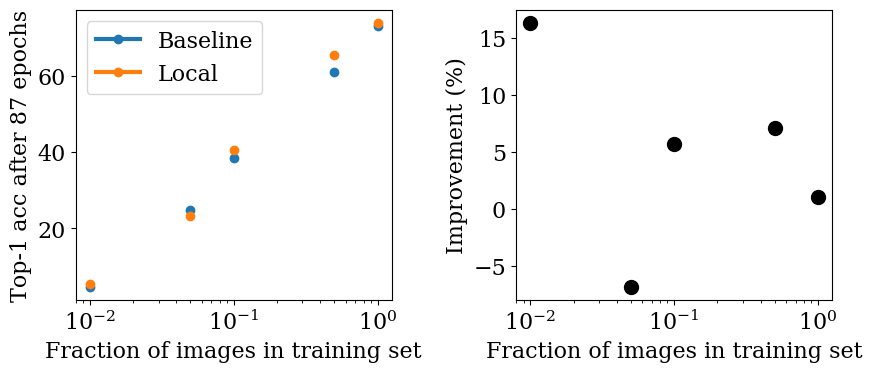

In [631]:
topk=1

fig, axarr = plt.subplots(1,2, figsize=(9,4))

x = defaultdict(list)
y = defaultdict(list)
colors = {False:'C0', True:'C1'}

for i, sampling_ratio in enumerate(params['sampling_ratio']):
    selected_runs, _ = select_runs(runs, params, {'sampling_ratio':sampling_ratio})
    time = min([len(run['logs']) for run in selected_runs])
    print([len(run['logs']) for run in selected_runs])
    print(sampling_ratio, time)
    perfs = {}
    for run in selected_runs:
        local = bool(run['args'].local_up_to_layer)
        perfs[local] = run['logs'][time-1]['test_acc1']
        axarr[0].plot(sampling_ratio, run['logs'][time-1]['test_acc1'], marker='o',
                         color=colors[local], label=(('Local' if local else 'Baseline') if i==0 else ''))
    axarr[1].plot(sampling_ratio, (perfs[True]-perfs[False])/perfs[False]*100, 
                  ls='none', marker='.', ms=20, color='k')
#y[True], y[False] = np.array(y[True]), np.array(y[False])

#for k in x.keys():
#    axarr[0].plot(x[k],y[k], ls='none', marker='.', ms=20, label=('Local' if k else 'Baseline'))
#    axarr[1].plot(x[False],(np.array(y[True])-np.array(y[False]))/np.array(y[False])*100, 
#                  ls='none', marker='.', ms=20, color='k')
for ax in axarr:
    ax.set_xscale('log')    
    ax.set_xlabel('Fraction of images in training set')
axarr[0].legend()
axarr[0].set_ylabel('Top-{} acc after {} epochs'.format(topk,latest))
axarr[1].set_ylabel('Improvement (%)'.format(topk))
plt.tight_layout()
plt.show()

137


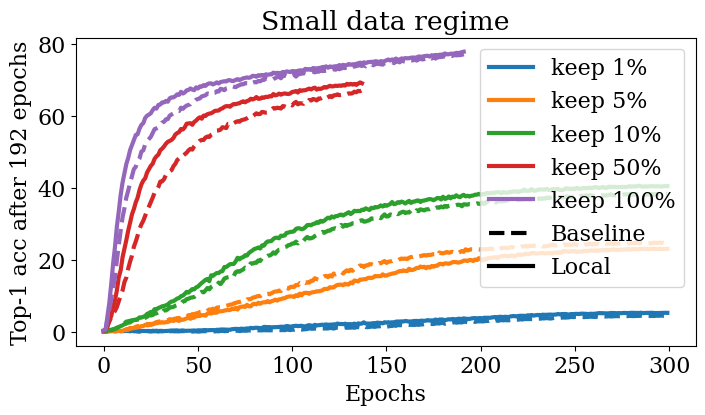

In [88]:
latest = min([len(run['logs']) for run in runs])-1
print(latest)
topk=1

plt.figure(figsize=(8,4))

for i, sampling_ratio in enumerate(params['sampling_ratio']):
    selected_runs, _ = select_runs(runs, params, {'sampling_ratio':sampling_ratio})
    latest = min([len(run['logs']) for run in selected_runs])
    for run in selected_runs:
        local = run['args'].local_up_to_layer
        plt.plot(range(latest), [run['logs'][k]['test_acc1'] for k in range(latest)], ls='-' if local else '--', 
                 label=('keep {0:.0f}%'.format(sampling_ratio*100)) if local else '',
                color = 'C%d'%i)

plt.plot([],[],color='k',label='Baseline', ls='--')
plt.plot([],[],color='k',label='Local')
plt.title('Small data regime')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Top-{} acc after {} epochs'.format(topk,latest))
plt.show()

# Class token

81


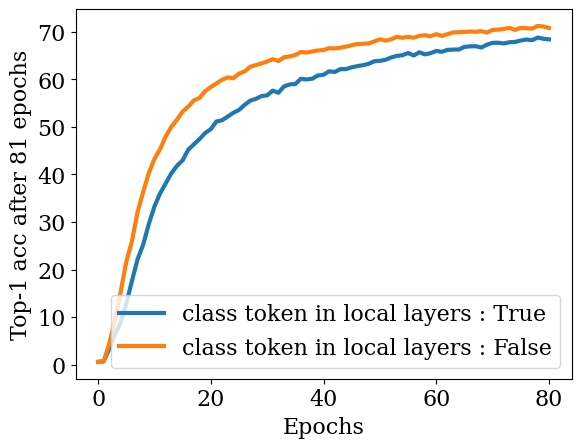

In [68]:
latest = min([len(run['logs']) for run in runs])-1
print(latest)
topk=1

plt.figure()

for run in runs:
    token = run['args'].class_token_in_local_layers
    plt.plot(range(latest), [run['logs'][k]['test_acc%d'%topk] for k in range(latest)], label='class token in local layers : {}'.format(token))
    #plt.plot(range(latest), [run['test'][k]['loss'] for k in range(latest)], color=cmap(n_local/12), label='{} local layers'.format(n_local))
    #plt.plot(range(latest), [run['train'][k]['loss'] for k in range(latest)], ls='--', color=cmap(n_local/12))
    
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Top-{} acc after {} epochs'.format(topk,latest))
plt.show()

# Models

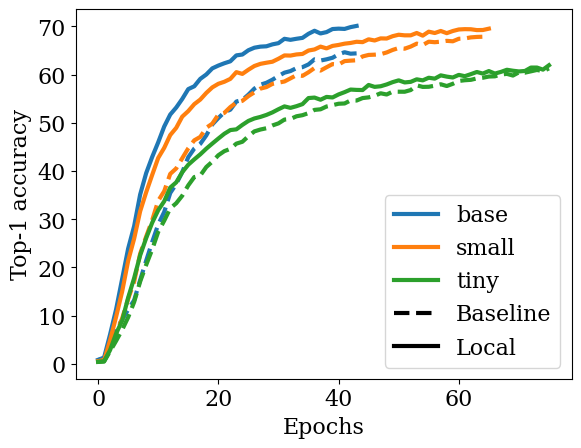

In [94]:
topk=1

plt.figure()

for i, model in enumerate(params['model']):
    selected_runs, _ = select_runs(runs, params, {'model':model})
    latest = min([len(run['logs']) for run in selected_runs])
    for run in selected_runs:
        local = run['args'].local_up_to_layer
        plt.plot(range(latest), [run['logs'][k]['test_acc1'] for k in range(latest)], ls='-' if local else '--', 
                 label=(model.split('_')[1]) if local else '',
                color = 'C%d'%i)

plt.plot([],[],color='k',label='Baseline', ls='--')
plt.plot([],[],color='k',label='Local')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Top-{} accuracy'.format(topk))
plt.show()

# Attention maps

In [34]:
import importlib
import main
importlib.reload(main)
from main import create_model, build_dataset
model = 'deit_small_patch16_224'
local_up_to_layer = 6
selected_runs, _ = select_runs(runs, params, {'model':model, 'local_up_to_layer':local_up_to_layer})
run = selected_runs[0]
model = create_model(model, local_up_to_layer=local_up_to_layer)
state_dict = torch.load(run['args'].output_dir/"checkpoint.pth")["model"]
model.load_state_dict(state_dict)
model.to('cuda')
num_patches = model.num_patches
img_size = int(num_patches**.5)
num_heads = model.blocks[0].attn.num_heads
embed_dim = model.embed_dim

args = run['args']
args.sampling_ratio = 0.001
dataset, _ = build_dataset(is_train=True, args=args)

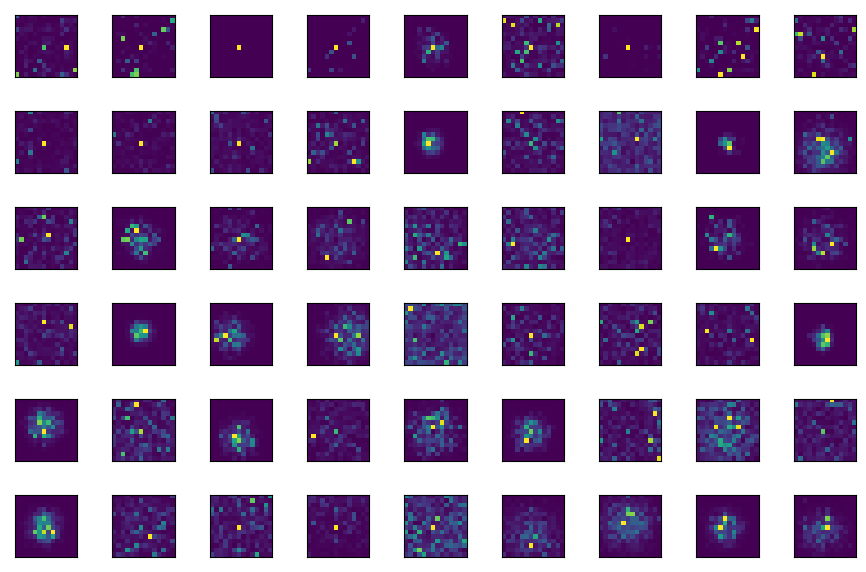

In [46]:
x = torch.randn(10,num_patches,embed_dim).to('cuda')
#plt.figure()
#x = dataset[6][0]
#plt.imshow(x.transpose(0,2))
#plt.axis('off')
#plt.show()
#x = x.unsqueeze(0).cuda()
#x = model.patch_embed(x)


fig, axarr = plt.subplots(6, num_heads, figsize=(num_heads,6))

for l in range(6):
    dist, attn_map = model.blocks[l].attn.get_attention_map(x, return_map=True)
    num_heads = len(attn_map)
    for head in range(num_heads):
        head_map = attn_map[head,104].detach().cpu().resize(img_size,img_size)
        axarr[l,head].matshow(head_map)
    for ax in axarr[l]:
        ax.set_xticks([]) 
        ax.set_yticks([]) 
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


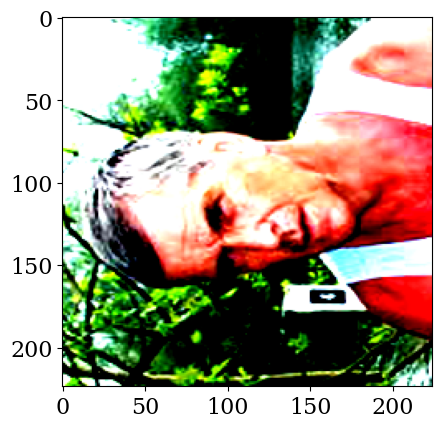